# __TerrorScope: Exploring Terrorist Hotspots Over Five Decades__

Created by: Taylor M. Smith

_**Description of Dataset:**_

This dataset contains detailed information about terrorist incidents that occurred from 1970 to 2017. It helps us understand when and where these incidents happened, what kind of attacks were involved, who the targets were, and how many people were affected. It also includes extra details like whether the incident took place on a working day or on July 4th. This data is useful for studying terrorism patterns and trends.Include details about its origin, the type of data it contains (e.g., date, location, nature of terrorist acts, casualties, etc.), and its overall scope (e.g., geographical coverage, time span).

_**Purpose Statement**_

The purpose of this project is to do a comprehensive analysis of terrorism trends and drivers, with the goal of enhancing understanding of the nature of terrorism, its evolution, and the factors that influence it. More notably, the purpose is to see the success trajectory of terrorist attacks over time.

_**Research Questions:**_

1. How have terrorism hotspots shifted globally over the last five decades?

2. Which factors contribute most significantly to the frequency and scale of terrorist attacks in different regions?

_**Methodology:**_

Four main steps are imployed in this exploration. First, the global terrorism dataset was used to create a new dataframe and preprocessed, addressing missing values and formatting issues. Second, exploratory data analysis was conducted to unveil insights into terrorism trends, including temporal and geographical patterns. Third, statistical models, such as logistic regression, were employed to analyze the impact of various features on terrorism outcomes, contributing to the investigation of patterns and factors. Finally, machine learning models, including random forests and neural networks, were used for predictive analysis and understanding the complexities of terrorism patterns.

In [33]:
# Importing required libraries
import pandas as pd
import xgboost as xgb
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.svm import SVC, SVR
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

# __**Importing Data & Preprocessing**__

In [34]:
# Reading in datafile
terrorism_data = pd.read_csv('global_terrorism.csv', encoding = 'ISO-8859-1', low_memory = False)
terrorism_data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [35]:
# Filtering the dataset to include relevant columns and years from the last 5 decades
start_year = 1970
end_year = 2017
terrorism_data = terrorism_data[(terrorism_data['iyear'] >= start_year) & (terrorism_data['iyear'] <= end_year)]

# Checking for and handling any missing data
terrorism_data.dropna(subset = ['eventid', 'iyear', 'country_txt', 'region_txt', 'longitude', 'latitude'], inplace = True)

# Sorting data by date
terrorism_data.sort_values(by = ['iyear', 'imonth', 'iday'], inplace = True)

# Creating GeoDataframe from the data
terrorism_gdf = gpd.GeoDataFrame(terrorism_data, 
                                  geometry = gpd.points_from_xy(terrorism_data.longitude, terrorism_data.latitude))

terrorism_data.dropna(subset = ['latitude', 'longitude'], inplace = True)

# __**Exploratory Data Analysis**__

**The heatmap was created here because it allowed for me to display terrorist attacks distributed across the geographic area of the world. This map is crucial to addressing the research questions related to the shifting of terrorist hotspots over time, and the factors that contribute to terrorist attacks in different regions.**

In [36]:
# Initializing a heatmap
m = folium.Map(location = [0, 0], zoom_start = 2)

heat_data = [[row['latitude'], row['longitude']] for index, row in terrorism_data.iterrows()]
HeatMap(heat_data).add_to(m)

# Heatmap is saved as an HTML file 
m.save('terrorism_heatmap.html')

__In this graph, we can see the change in the number of terrorist attacks from 1970 until ~2011 where there is a steep increase up through ~2013, where terrorism all around the globe reached a peak high.__

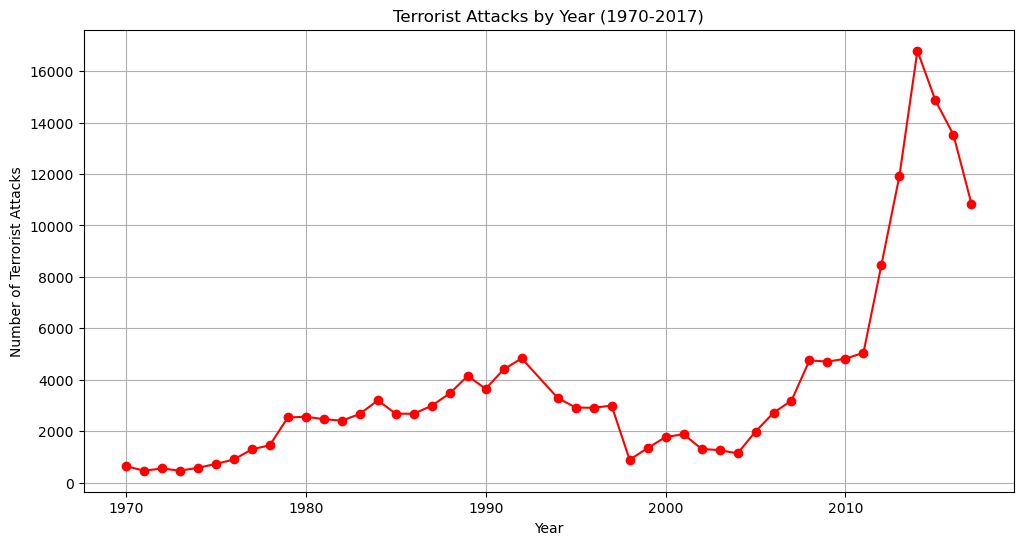

In [37]:
# Plotting the number of terrorist attacks by year
plt.figure(figsize = (12, 6))
terrorism_data['iyear'].value_counts().sort_index().plot(kind = 'line', marker = 'o', color = 'red')
plt.title('Terrorist Attacks by Year (1970-2017)')
plt.xlabel('Year')
plt.ylabel('Number of Terrorist Attacks')
plt.grid(True)
plt.show()

__In this graph, the top 10 countries that had the highest frequeny of terrorist attacks from 1970-2017. The bar plot was important here as it allowed for a visual representation of highest number to lowest number (of attacks).__

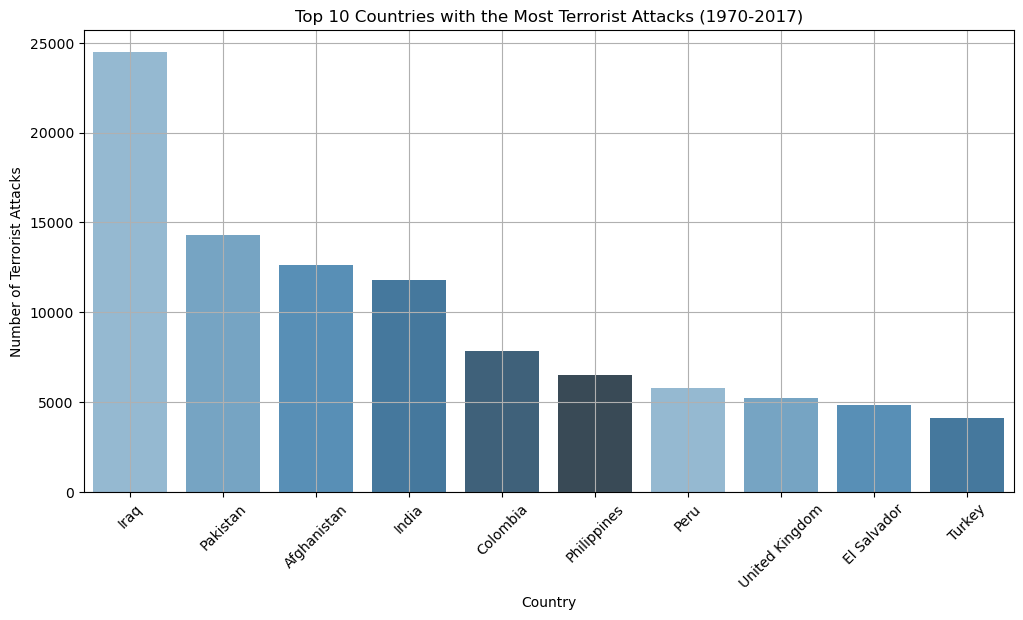

In [38]:
# Defining terrorist attacks by country
blue_palette = sns.color_palette("Blues_d")

plt.figure(figsize = (12, 6))
sns.countplot(
    x = 'country_txt',
    data = terrorism_data,
    order = terrorism_data['country_txt'].value_counts().index[:10],
    palette = blue_palette  
)

plt.title('Top 10 Countries with the Most Terrorist Attacks (1970-2017)')
plt.xlabel('Country')
plt.ylabel('Number of Terrorist Attacks')
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

__This graph breaks down the various types of attacks methods that terrorists used to carry out their attacks.__

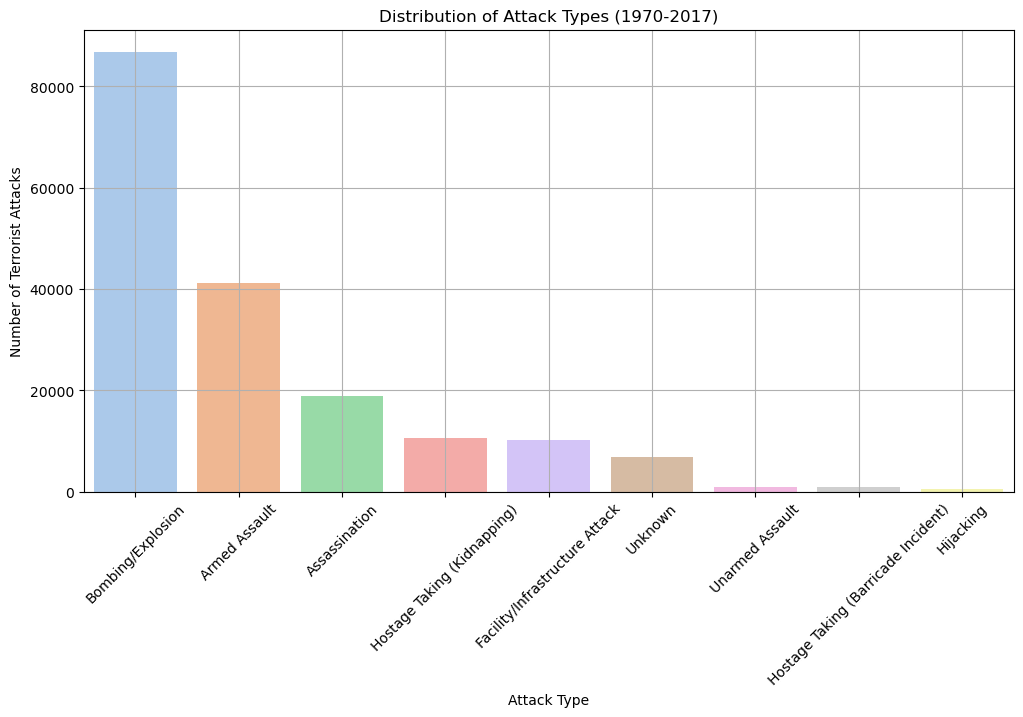

In [39]:
# Defining terrorist attack types
plt.figure(figsize = (12, 6))
sns.countplot(x = 'attacktype1_txt', data = terrorism_data, order = terrorism_data['attacktype1_txt'].value_counts().index)

pastel_palette = sns.color_palette("pastel")

sns.countplot(
    x = 'attacktype1_txt',
    data = terrorism_data,
    order = terrorism_data['attacktype1_txt'].value_counts().index,
    palette = pastel_palette
)

plt.title('Distribution of Attack Types (1970-2017)')
plt.xlabel('Attack Type')
plt.ylabel('Number of Terrorist Attacks')
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

__This pie chart helps to understand the amount of terrorist attacks that were planned and failed vs those that were successful.__

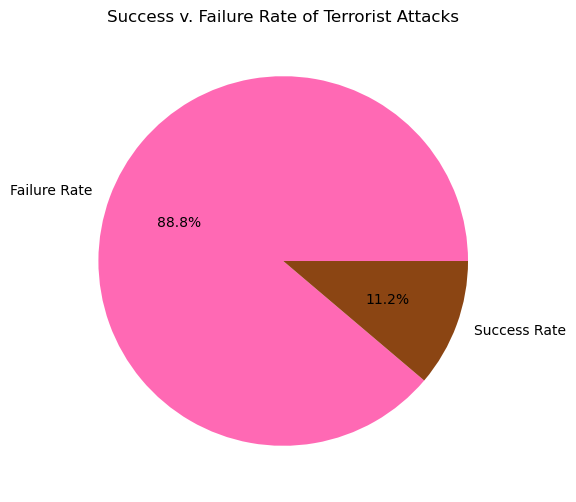

In [40]:
# Displaying success rate of terrorist attacks
plt.figure(figsize = (6, 6))
colors = ['#FF69B4', '#8B4513']
terrorism_data['success'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', labels = ['Failure Rate', 'Success Rate'], colors = colors)
plt.title('Success v. Failure Rate of Terrorist Attacks')
plt.ylabel('')
plt.show()

__Here, the distributions of two numeric features 'nkill' & 'nwound' (both of which show the number of people that were wounded vs those that were killed) - this visualization helps to shed light on the distribbution of casualties in terrorist attacks, shedding light on the severity of the attacks.__

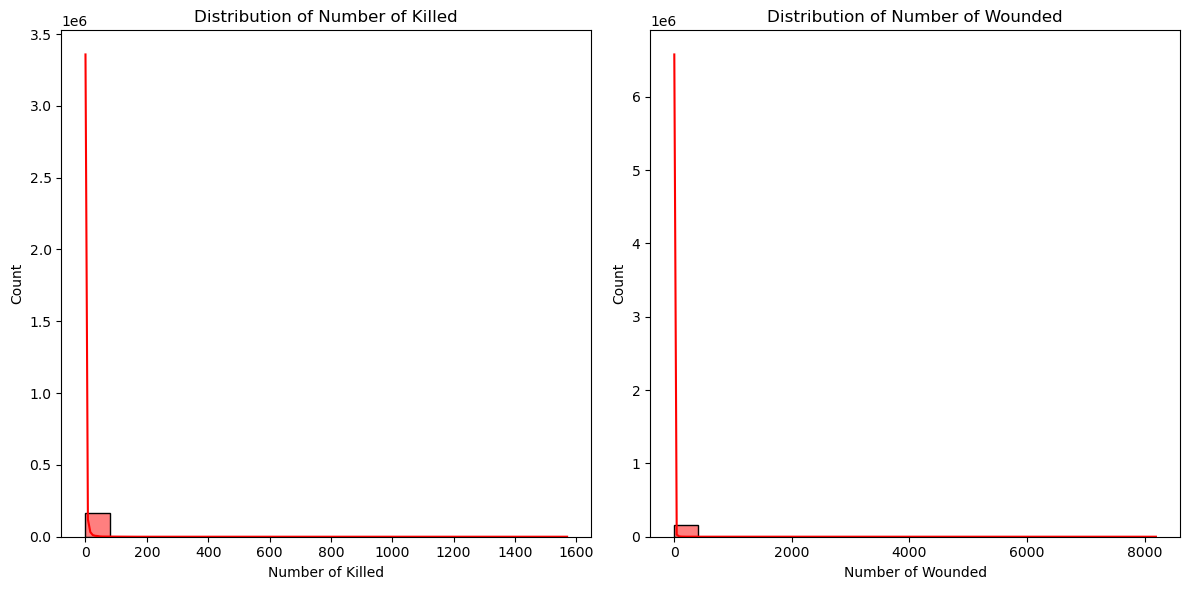

In [41]:
# Plotting histograms for numeric features ('nkill' and 'nwound')
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
sns.histplot(terrorism_data['nkill'], bins = 20, kde = True, color = 'red')
plt.title('Distribution of Number of Killed')
plt.xlabel('Number of Killed')

plt.subplot(1, 2, 2)
sns.histplot(terrorism_data['nwound'], bins = 20, kde = True, color = 'red')
plt.title('Distribution of Number of Wounded')
plt.xlabel('Number of Wounded')

plt.tight_layout()
plt.show()

__Here, a times series plot is generated showing the trend of the terrorist attacks over the years. This also helps to show the frequency of these attacks.__

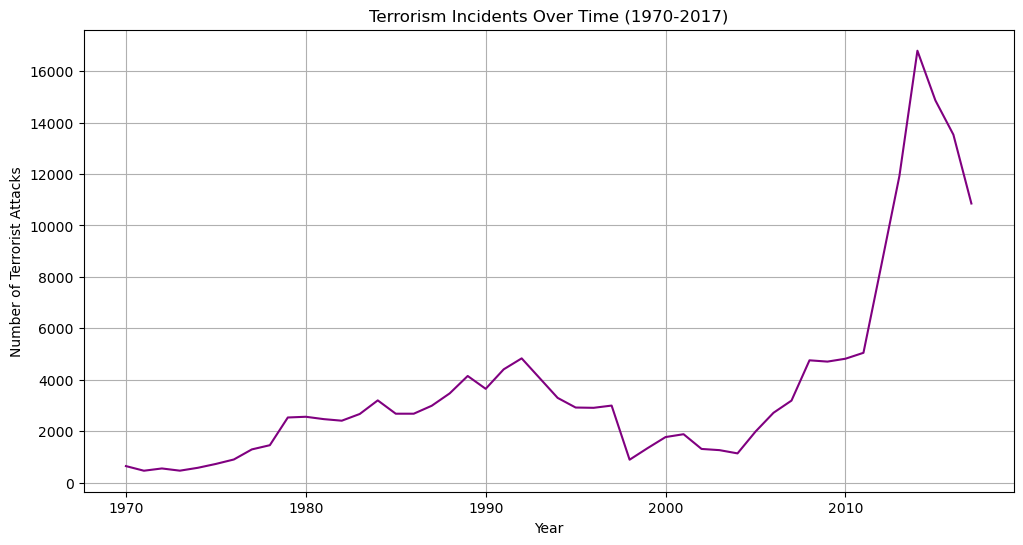

In [42]:
# Performing time series analysis of terrorism incidents over the years
plt.figure(figsize = (12, 6))
terrorism_data.groupby('iyear').size().plot(kind = 'line', color = 'purple', title = 'Terrorism Incidents Over Time (1970-2017)')
plt.xlabel('Year')
plt.ylabel('Number of Terrorist Attacks')
plt.grid(True)

plt.show()

__This scatterplot visualizes the locations of terrorist attacks on a geographical map - the colors are used here to differientiate regions and provide insights into where the attacks have occured.__

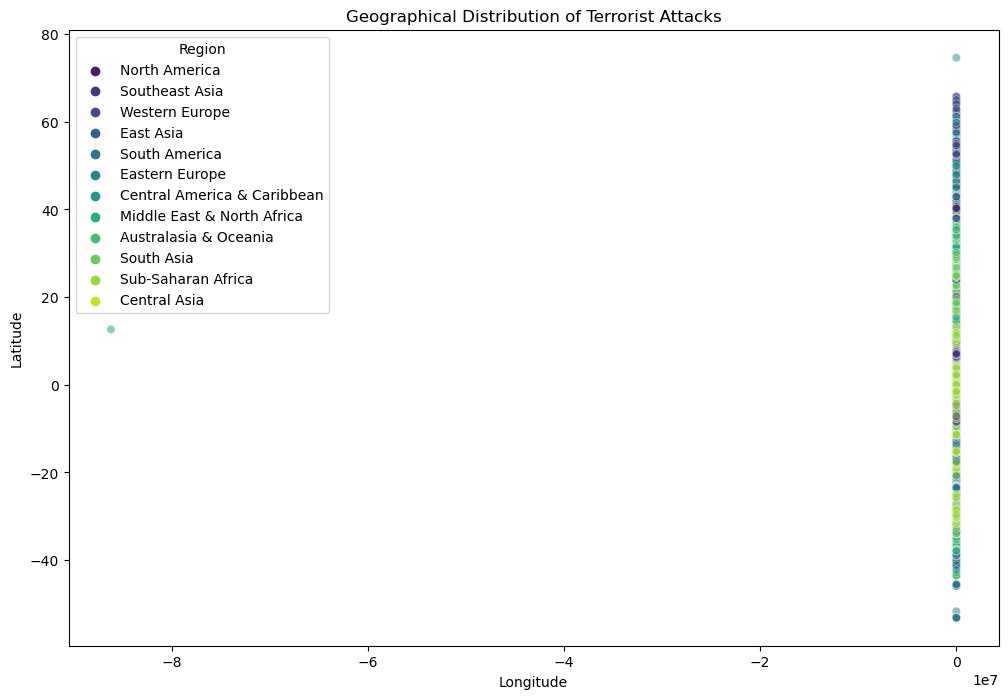

In [43]:
# Plotting a geographical distribution of terrorism incidents (longitude and latitude)
plt.figure(figsize = (12, 8))
sns.scatterplot(x = 'longitude', y = 'latitude', data = terrorism_data, hue = 'region_txt', palette = 'viridis', alpha = 0.5)
plt.title('Geographical Distribution of Terrorist Attacks')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title = 'Region')
plt.show()

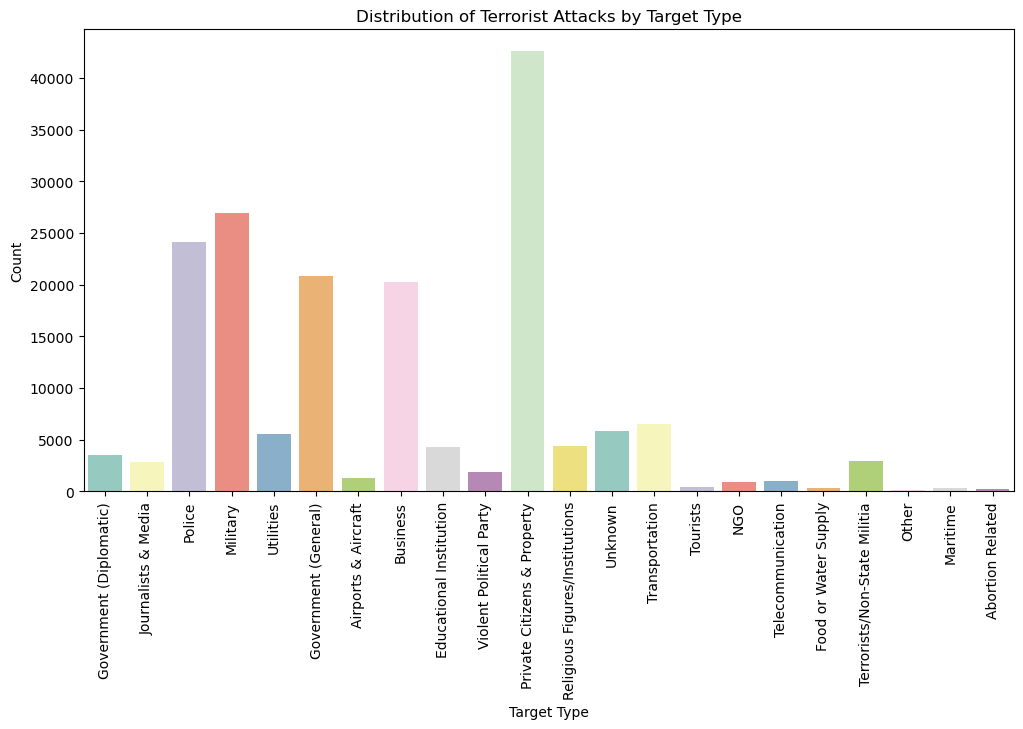

In [44]:
# Bar chart showing the distribution of terrorist incidents by target type
plt.figure(figsize = (12, 6))
sns.countplot(x = 'targtype1_txt', data = terrorism_data, palette = 'Set3')
plt.title('Distribution of Terrorist Attacks by Target Type')
plt.xlabel('Target Type')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

# __**Feature Engineering**__

__The following code is all about making sense of dates in a dataset about terrorist incidents. First, it combines year, month, and day columns into a single date format. Then, it converts these combined strings into proper date values. Any invalid or missing dates are spotted and removed. Next, it extracts useful details like the year, month, day, and the day of the week for each incident. Additionally, it identifies if an incident took place on July 4th. The process helps organize and enrich the date information for better analysis and understanding of when these events occurred.__

In [45]:
date_str = terrorism_data['iyear'].astype(str) + '-' + terrorism_data['imonth'].astype(str).str.zfill(2) + '-' + terrorism_data['iday'].astype(str).str.zfill(2)

terrorism_data['date'] = pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce')

# Checking for rows with invalid dates (NaT) and dropping them if necessary
invalid_date_rows = terrorism_data[terrorism_data['date'].isna()]
if not invalid_date_rows.empty:
    print(f"Invalid date rows: {len(invalid_date_rows)}")

# Dropping row with invalid dates
terrorism_data = terrorism_data.dropna(subset = ['date'])

# Extracting year, month, and day from the 'iyear,' 'imonth,' and 'iday' columns
terrorism_data['year'] = terrorism_data['date'].dt.year
terrorism_data['month'] = terrorism_data['date'].dt.month
terrorism_data['day'] = terrorism_data['date'].dt.day

# Calculating the day of the week for each incident
terrorism_data['day_of_week'] = terrorism_data['date'].dt.day_name()

terrorism_data['is_july_4th'] = (terrorism_data['month'] == 7) & (terrorism_data['day'] == 4)

print(terrorism_data[['year', 'month', 'day', 'day_of_week', 'is_july_4th']].head())

Invalid date rows: 804
    year  month  day day_of_week  is_july_4th
5   1970      1    1    Thursday        False
10  1970      1    1    Thursday        False
6   1970      1    2      Friday        False
7   1970      1    2      Friday        False
8   1970      1    2      Friday        False


__Here, a new feature called 'is_working_day' is created based on the 'is_weekend' feature. The 'is_working_day' feature assigns a value of 1 to working days (weekdays) and 0 to non-working days (weekends), providing a binary representation of whether an incident occurred on a working day or not.__

In [46]:
# Creating a feature to represent weekdays (1) and weekends (0)
terrorism_data['is_weekend'] = (terrorism_data['day_of_week'].isin(['Saturday', 'Sunday'])).astype(int)

# Creating a feature to represent working days (1) and non-working days (0)
terrorism_data['is_working_day'] = terrorism_data['is_weekend'].apply(lambda x: 1 if x == 0 else 0)

print(terrorism_data['is_working_day'].unique())

[1 0]


__The dataset is prepared by creating features to indicate whether incidents occurred during business hours, performing one-hot encoding for attack types, and calculating the annual averages for people killed and wounded. These steps are vital for subsequent analysis and modeling to answer research questions effectively.__

In [47]:
# Creating a feature to represent whether an incident occurred during business hours (9 AM - 5 PM)
terrorism_data['is_business_hours'] = ((terrorism_data['date'].dt.hour >= 9) & (terrorism_data['date'].dt.hour < 17)).astype(int)

# Performing one-hot encoding for the 'attacktype1_txt' column
attacktype1_dummies = pd.get_dummies(terrorism_data['attacktype1_txt'], prefix = 'attacktype', drop_first = True)
terrorism_data = pd.concat([terrorism_data, attacktype1_dummies], axis = 1)

# Calculating the average # of people killed and wounded per year
avg_killed_per_year = terrorism_data.groupby('year')['nkill'].mean()
avg_wounded_per_year = terrorism_data.groupby('year')['nwound'].mean()

print(avg_killed_per_year)
print (avg_wounded_per_year)

year
1970    0.224662
1971    0.422785
1972    1.075697
1973    0.888889
1974    1.044747
1975    1.091071
1976    0.823755
1977    0.381407
1978    1.054911
1979    0.831921
1980    1.965222
1981    2.461160
1982    2.993831
1983    4.318975
1984    3.366293
1985    2.586928
1986    1.948423
1987    2.075465
1988    1.813953
1989    1.830129
1990    1.777808
1991    1.790259
1992    1.770242
1994    2.193015
1995    1.954655
1996    2.135816
1997    3.340505
1998    4.859172
1999    2.527670
2000    2.509221
2001    3.973355
2002    3.651144
2003    2.605348
2004    5.047279
2005    3.176829
2006    3.486600
2007    4.030852
2008    1.932182
2009    1.973926
2010    1.624032
2011    1.640153
2012    1.870612
2013    1.912905
2014    2.805981
2015    2.749183
2016    2.729802
2017    2.571526
Name: nkill, dtype: float64
year
1970     0.362543
1971     0.229299
1972     1.863014
1973     2.115385
1974     2.514535
1975     1.520107
1976     1.168081
1977     0.469043
1978     1.224083
1

__Here, I merge the calculated annual averages for people killed and wounded back into the dataset, creating new columns with these average values. Additionally, it calculates an interaction feature by multiplying the 'nkill' and 'nwound' columns, aiming to capture potential combined effects of both variables in the data. These steps enrich the dataset with aggregated information and interaction features for more comprehensive analysis and modeling.__

In [48]:
terrorism_data = terrorism_data.merge(avg_killed_per_year, on='year', suffixes=('', '_avg_killed'))
terrorism_data = terrorism_data.merge(avg_wounded_per_year, on='year', suffixes=('', '_avg_wounded'))

# Creating an interaction feature between 'nkill' and 'nwound'
terrorism_data['nkill_nwound_interaction'] = terrorism_data['nkill'] * terrorism_data['nwound']

__A new column called 'cluster' is created in the dataset, which represents cluster labels obtained by applying K-means clustering to the latitude and longitude coordinates of terrorism incidents. It segments the incidents into five distinct clusters based on their geographical locations, allowing for spatial patterns and relationships to be considered in further analysis.__

In [49]:
# Creating new df for clustering
coordinates = terrorism_data[['latitude', 'longitude']]

# Specifying 5 clusters
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
terrorism_data['cluster'] = kmeans.fit_predict(coordinates)

# Displaying cluster labels
print(terrorism_data[['latitude', 'longitude', 'cluster']].head())

/Users/tms/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    latitude   longitude  cluster
0  37.005105  -89.176269        3
1  43.468500  -89.744299        3
2 -34.891151  -56.187214        3
3  37.791927 -122.225906        3
4  43.076592  -89.412488        3


__The results of the clustering technique above indicate that all of the data points here belong to cluster 3.__

# __**Statistical Analysis**__

__Here, a time series analysis is performed of terrorism incidents for different regions over the years. It first identifies the unique regions in the dataset and then iterates through each region. For each region, a  line plot is created showing the number of terrorist attacks over time (years). The x-axis represents the years, the y-axis represents the number of terrorist attacks, and each plot is specific to a particular region. This helps visualize how the frequency of terrorist incidents has changed over time for various geographic regions.__

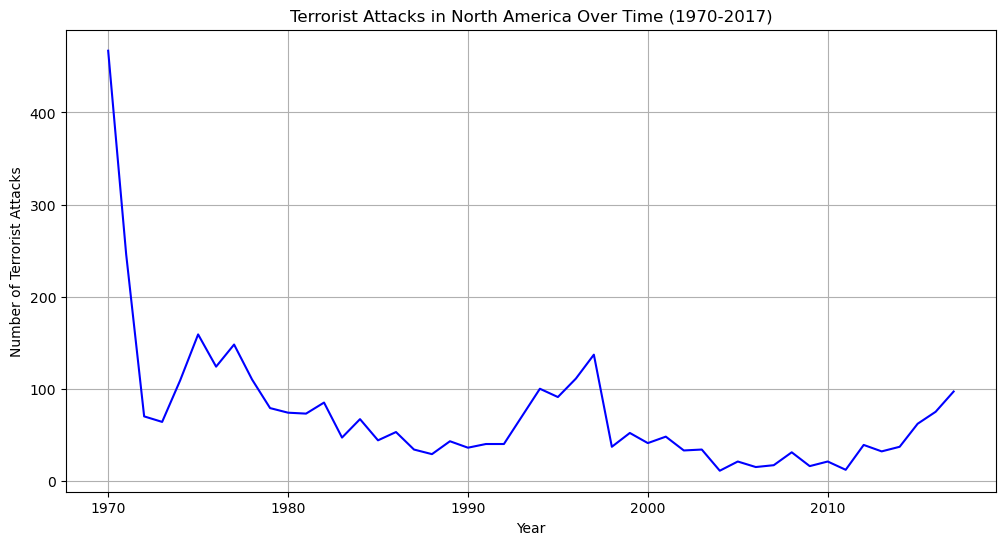

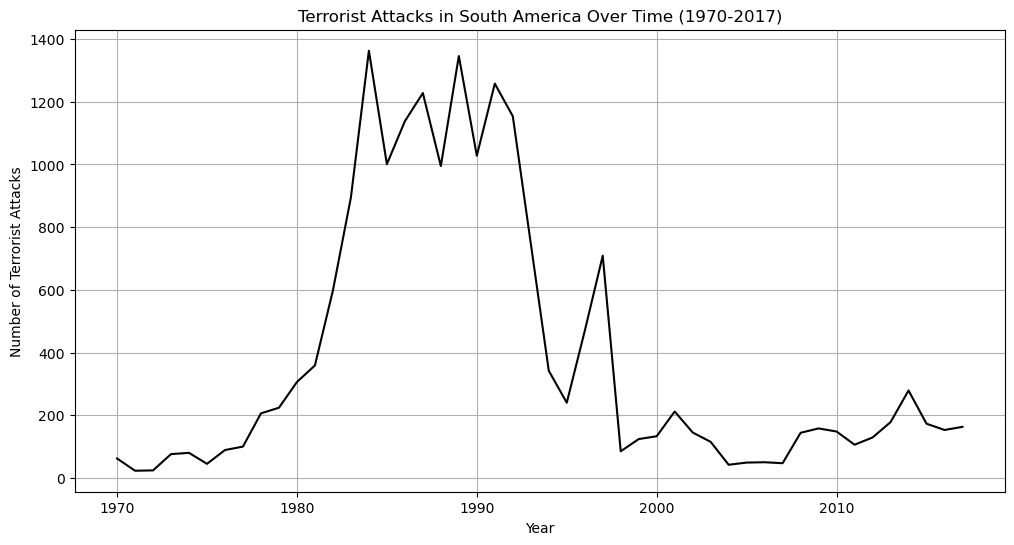

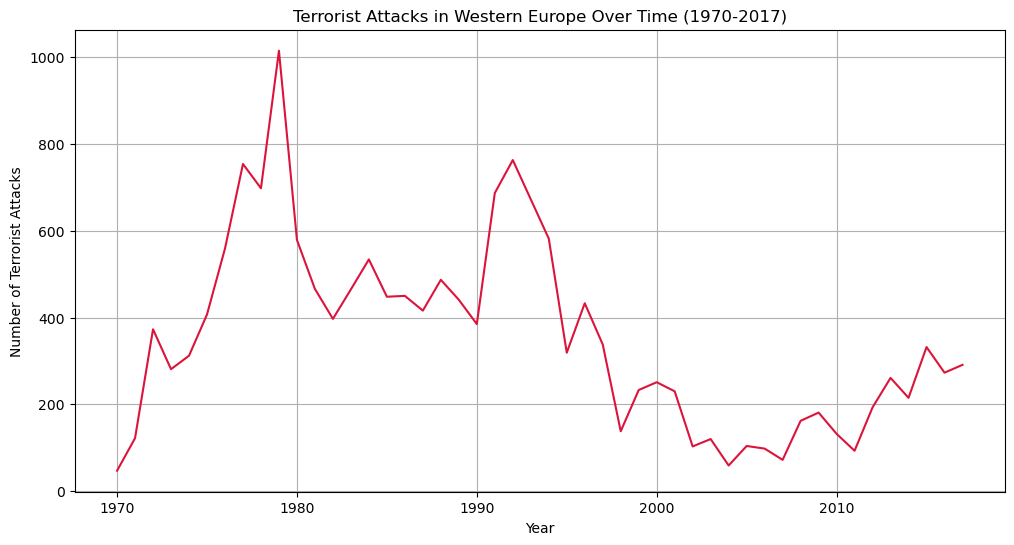

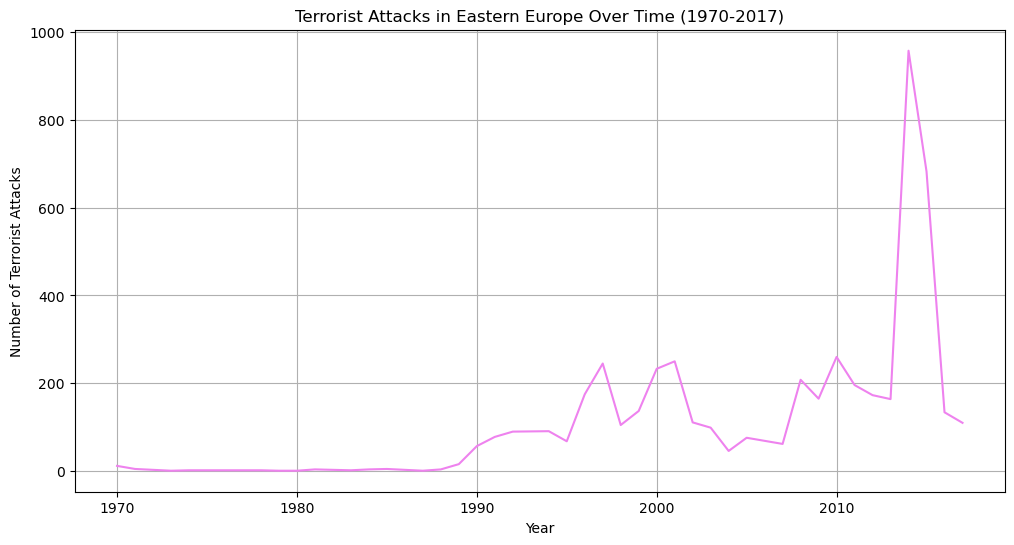

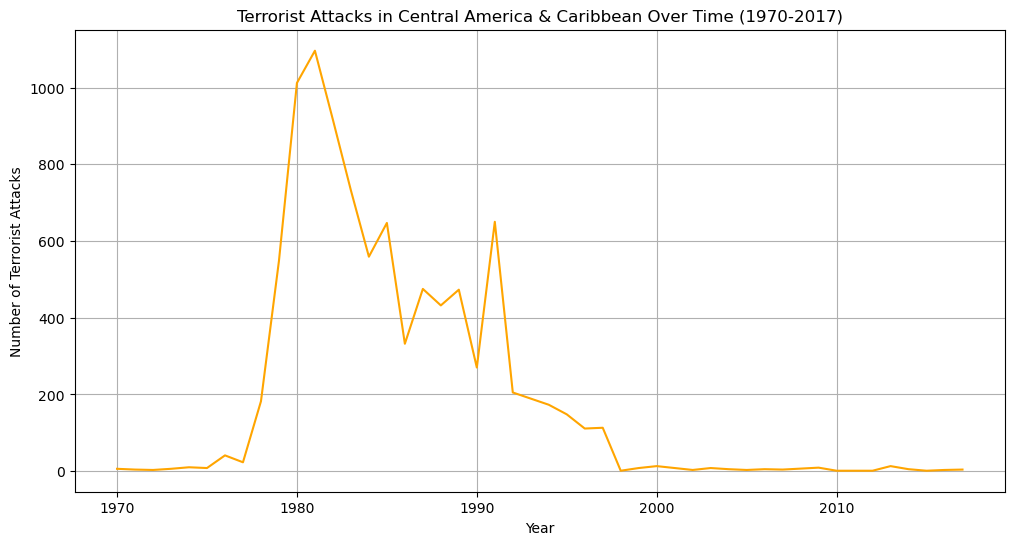

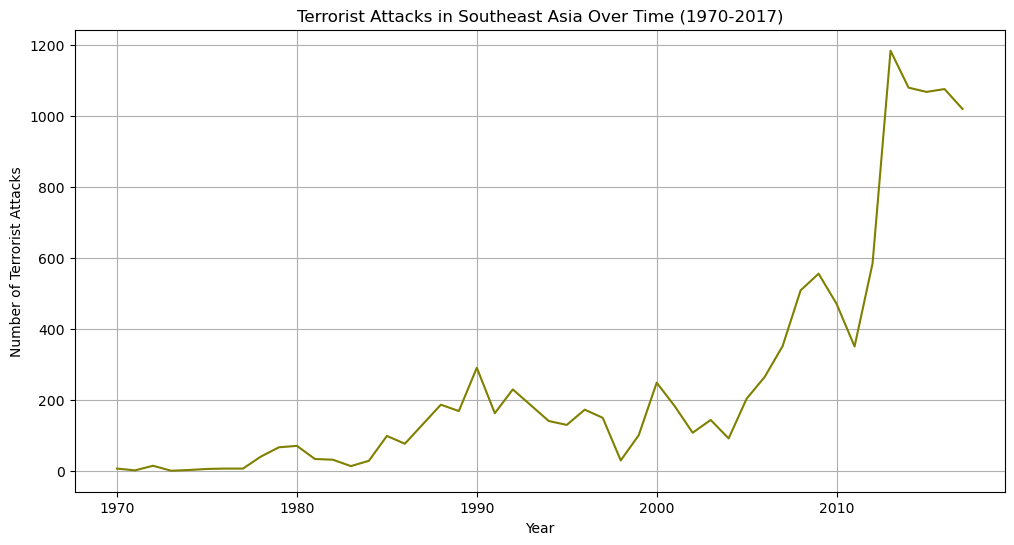

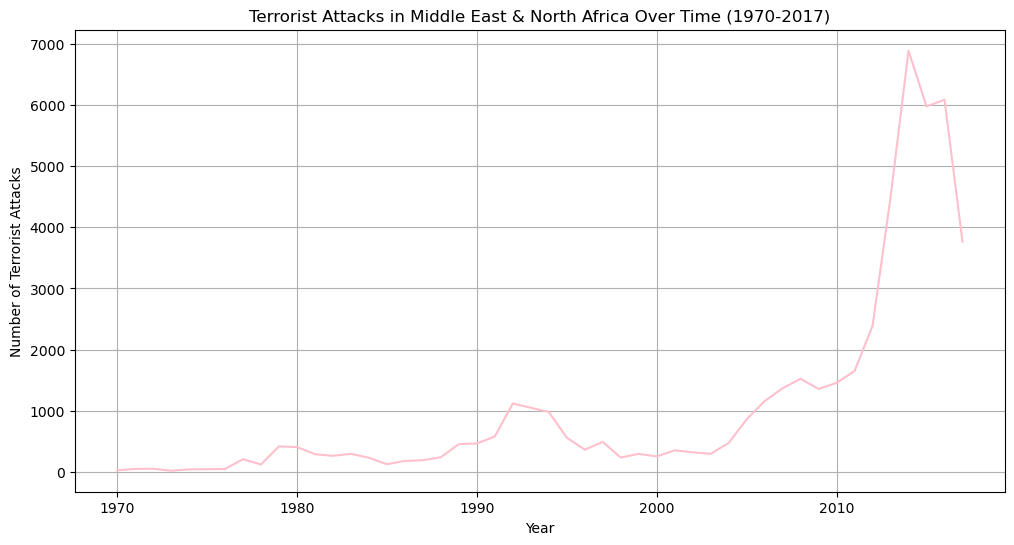

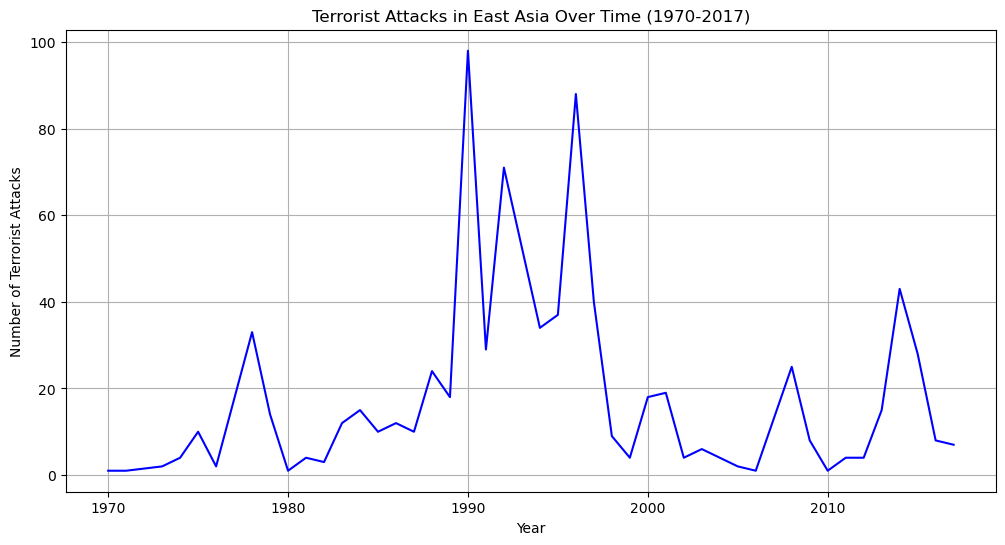

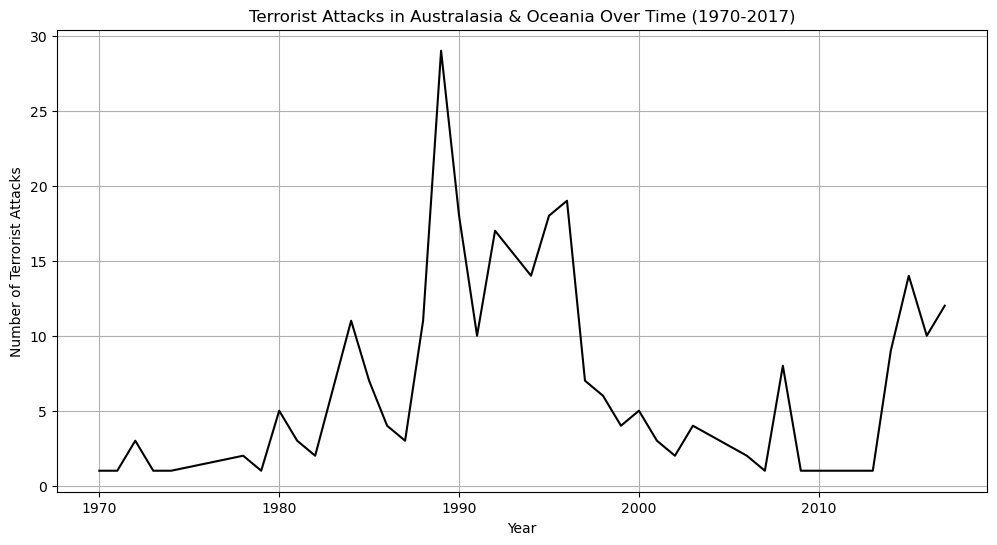

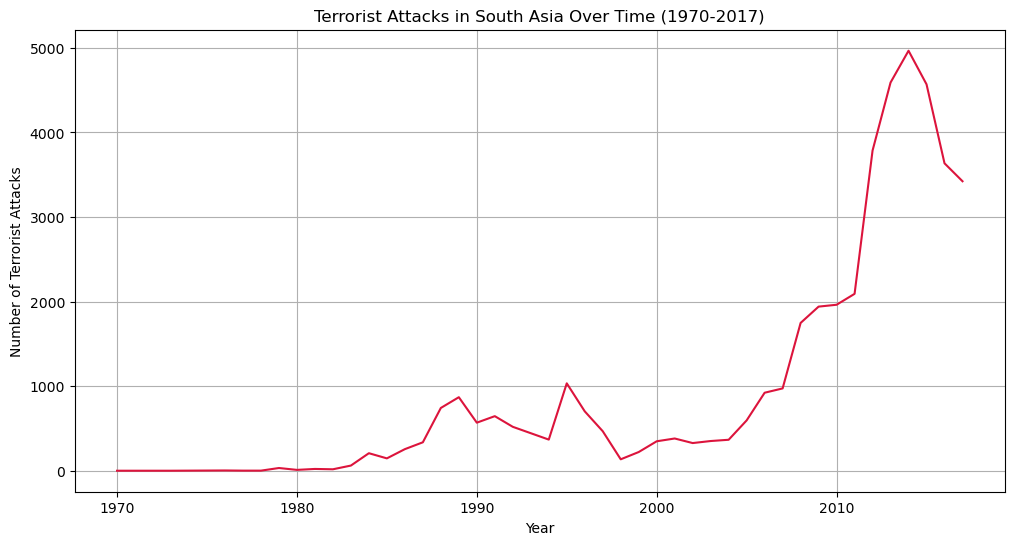

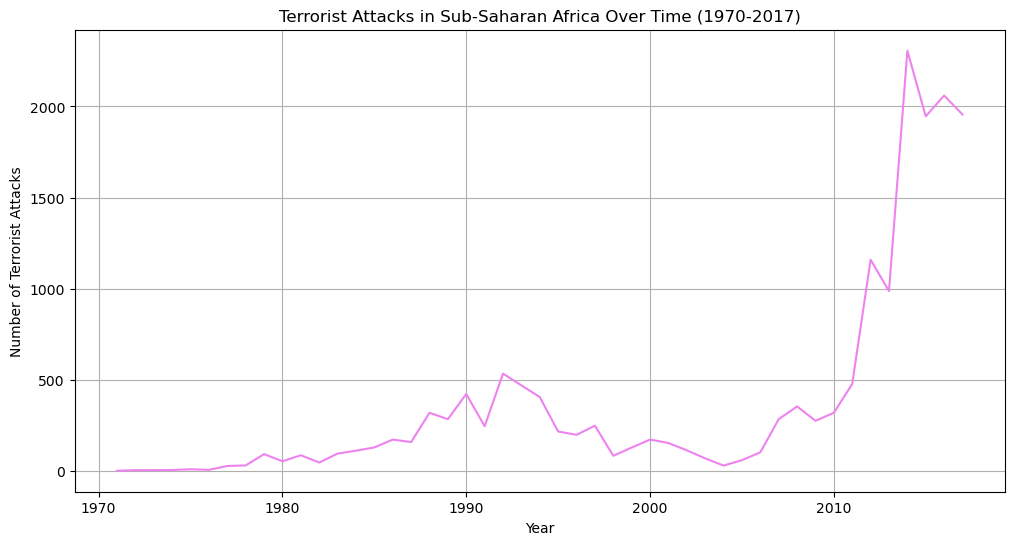

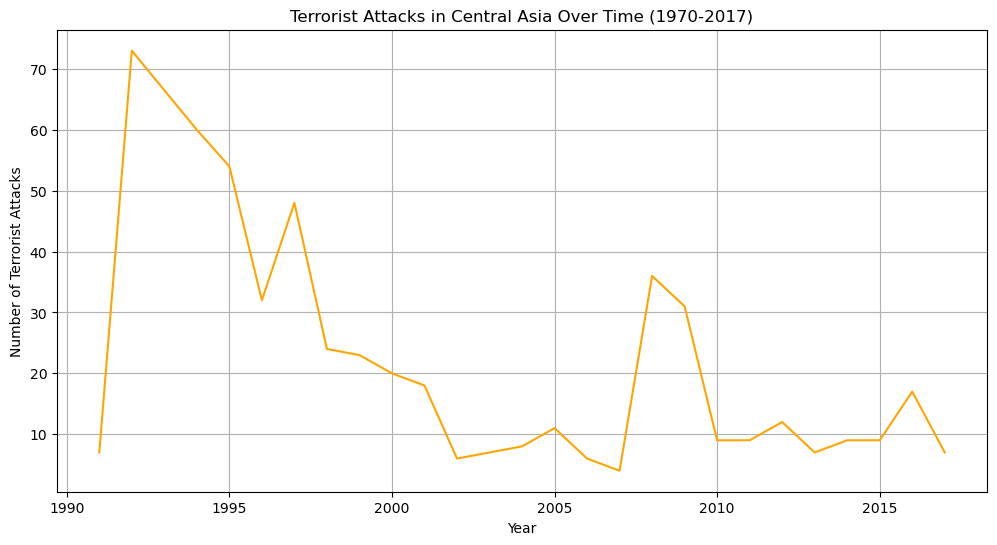

In [50]:
# Time series analysis of terrorism incidents by region over the years
regions = terrorism_data['region_txt'].unique()

colors = ['blue', 'black', 'crimson', 'violet', 'orange', 'olive', 'pink']

# Repeating the list of colors (there are more regions than colors)
colors = colors * ((len(regions) // len(colors)) + 1)

for i, region in enumerate(regions):
    region_data = terrorism_data[terrorism_data['region_txt'] == region]
    
    plt.figure(figsize=(12, 6))
    region_data.groupby('iyear').size().plot(kind='line', color=colors[i])
    plt.title(f'Terrorist Attacks in {region} Over Time (1970-2017)')
    plt.xlabel('Year')
    plt.ylabel('Number of Terrorist Attacks')
    plt.grid(True)
    plt.show()

__Here, I performed a linear regression analysis for selected features (such as 'attacktype1' and 'targtype1') in different regions to understand their impact on the number of killed ('nkill') in terrorist incidents. This analysis aims to identify and quantify the factors that have a significant influence on the scale of terrorist attacks in specific regions.__

In [51]:
# Defining the selected features
selected_features = ['nperps', 'nwound', 'iyear']

# Defining the selected regions
selected_regions = ['Middle East & North Africa', 'South Asia', 'Sub-Saharan Africa']

for region in selected_regions:
    region_data = terrorism_data[terrorism_data['region_txt'] == region]
    
    # Checking and dropping rows with missing values
    region_data = region_data.dropna(subset=selected_features + ['nkill'])
    
    X = sm.add_constant(region_data[selected_features])
    y = region_data['nkill']  #  == Dependent variable
    
    # Fitting the linear regression model
    model = sm.OLS(y, X).fit()  
    print(f'Region: {region}')
    print(model.summary())

Region: Middle East & North Africa
                            OLS Regression Results                            
Dep. Variable:                  nkill   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     2827.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:28:06   Log-Likelihood:            -1.2286e+05
No. Observations:               35579   AIC:                         2.457e+05
Df Residuals:                   35575   BIC:                         2.458e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -159.

__The regression analysis for the Middle East & North Africa region reveals that the number of perpetrators (nperps), the number of wounded individuals (nwound), and the passage of time (iyear) are statistically significant factors contributing to the number of people killed in terrorist incidents. Specifically, an increase in the number of perpetrators or wounded individuals is associated with a higher number of casualties. Additionally, as time progresses, there is a gradual increase in the number of people killed in terrorist attacks in the region.__

__Here, I perform a linear regression analysis to understand the relationship between the dependent variable 'property' (indicating property damage) and the independent variables 'attacktype1' (attack type) and 'targtype1' (target type). The linear regression model is fitted, and a summary of the regression results is printed, which includes coefficients, p-values, R-squared values. The analysis here aims to investigate how 'attacktype1' and 'targtype1' contribute to explaining variations in property damage in terrorist incidents, providing insights into the factors influencing property damage in such events.__

In [52]:
y = terrorism_data['property']  # Property damage is the dependent variable here
X = sm.add_constant(terrorism_data[['attacktype1', 'targtype1']])  

# Fitting a linear regression model
model = sm.OLS(y, X).fit()

# Regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               property   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     97.48
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           4.90e-43
Time:                        18:28:06   Log-Likelihood:            -4.5224e+05
No. Observations:              176330   AIC:                         9.045e+05
Df Residuals:                  176327   BIC:                         9.045e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7585      0.017    -43.392      

__The regression results for the impact of 'attacktype1' and 'targtype1' on property damage (property) indicate that these factors collectively explain a small portion of the variation in property damage. The R-squared value of 0.001 suggests that only 0.1% of the variance in property damage can be explained by the chosen features. Specifically, the type of attack (attacktype1) has a statistically significant positive coefficient, indicating that different attack types tend to cause higher property damage. However, the type of target (targtype1) does not have a statistically significant impact on property damage, as indicated by its p-value of 0.172. Overall, while there is a significant relationship between attack type and property damage, the effect size is relatively small in explaining property damage variation.__

# __**Machine Learning Models**__

__The data here is prepared for machine learning by selecting the features (attacktype1, targtype1, weaptype1, and region) and the target variable (success) for classification. It also removes rows with missing values in any of these selected columns. Afterward, the dataset is split into training and testing sets, where X_train and y_train contain the feature variables and target variable for training, and X_test and y_test contain the feature variables and target variable for testing.__

In [53]:
# Selecting features and target variable
features = ['attacktype1', 'targtype1', 'weaptype1', 'region']
target = 'success'

# Dropping rows with missing values
terrorism_data = terrorism_data.dropna(subset=features + [target])

# Splitting the data into training and testing sets
X = terrorism_data[features]
y = terrorism_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

_**Random Forest Classifier**_

In [54]:
clf = RandomForestClassifier(random_state = 42)
clf.fit(X_train, y_train)

# Making predictions on the test set
y_pred = clf.predict(X_test)

# Evaluating the model's accuracy 
accuracy = accuracy_score(y_test, y_pred)

# Providing the classification report 
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('\n Random Forest Classification Report:\n', report)

Accuracy: 0.90

 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.29      0.40      3988
           1       0.92      0.98      0.95     31278

    accuracy                           0.90     35266
   macro avg       0.79      0.64      0.68     35266
weighted avg       0.89      0.90      0.89     35266



_**Neural Network Classifier**_

In [55]:
# Standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Defining the neural network architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation = 'relu', input_shape = (X_train.shape[1],)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')  # Output layer for binary classification
])

# Compiling the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2, verbose = 2)

# Evaluating the model on the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculating accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

print(f'Accuracy: {accuracy:.2f}')
print('Neural Network Classification Report:\n', report) 

Epoch 1/10
3527/3527 - 1s - loss: 0.3213 - accuracy: 0.8893 - val_loss: 0.3131 - val_accuracy: 0.8905 - 1s/epoch - 370us/step
Epoch 2/10
3527/3527 - 1s - loss: 0.3059 - accuracy: 0.8916 - val_loss: 0.3084 - val_accuracy: 0.8914 - 1s/epoch - 315us/step
Epoch 3/10
3527/3527 - 1s - loss: 0.3031 - accuracy: 0.8925 - val_loss: 0.3070 - val_accuracy: 0.8914 - 1s/epoch - 325us/step
Epoch 4/10
3527/3527 - 1s - loss: 0.3013 - accuracy: 0.8933 - val_loss: 0.3041 - val_accuracy: 0.8942 - 1s/epoch - 339us/step
Epoch 5/10
3527/3527 - 1s - loss: 0.3002 - accuracy: 0.8935 - val_loss: 0.3045 - val_accuracy: 0.8953 - 1s/epoch - 312us/step
Epoch 6/10
3527/3527 - 1s - loss: 0.2987 - accuracy: 0.8950 - val_loss: 0.3030 - val_accuracy: 0.8914 - 1s/epoch - 333us/step
Epoch 7/10
3527/3527 - 1s - loss: 0.2974 - accuracy: 0.8961 - val_loss: 0.3024 - val_accuracy: 0.8913 - 1s/epoch - 315us/step
Epoch 8/10
3527/3527 - 1s - loss: 0.2964 - accuracy: 0.8970 - val_loss: 0.3010 - val_accuracy: 0.8984 - 1s/epoch - 309

_**Decision Tree Classifier**_

In [56]:
clf = DecisionTreeClassifier(random_state = 42)
clf.fit(X_train, y_train)

# Making predictions on the test set
y_pred = clf.predict(X_test)

# Evaluating the model's accuracy
accuracy = accuracy_score(y_test, y_pred)

# Providing the classification report
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('\nDecision Tree Classification Report:\n', report)

Accuracy: 0.90

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.29      0.40      3988
           1       0.92      0.98      0.95     31278

    accuracy                           0.90     35266
   macro avg       0.79      0.64      0.68     35266
weighted avg       0.89      0.90      0.89     35266



_**Support Vector Machine Classifier**_

In [62]:
# Creating and train an SVM classifier
svm_classifier = SVC(kernel = 'linear', random_state = 42)
svm_classifier.fit(X_train, y_train)

# Making predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluating the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print("SVM Classifier:")
print(f'Accuracy: {accuracy_svm:.2f}')
print('\n Support Vector Machine (SVM) Classification Report:\n', report_svm)

SVM Classifier:
Accuracy: 0.89

 Support Vector Machine (SVM) Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3988
           1       0.89      1.00      0.94     31278

    accuracy                           0.89     35266
   macro avg       0.44      0.50      0.47     35266
weighted avg       0.79      0.89      0.83     35266



/Users/tms/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tms/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tms/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_**K-Nearest Neighbors Classifier**_

In [58]:
# Creating and training a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors = 5)
knn_classifier.fit(X_train, y_train)

# Making predictions
y_pred_knn = knn_classifier.predict(X_test)

# Evaluating the KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print("K-Nearest Neighbors (KNN) Classifier:")
print(f'Accuracy: {accuracy_knn:.2f}')
print('\n K-Nearest Neighbors Classification Report:\n', report_knn)

K-Nearest Neighbors (KNN) Classifier:
Accuracy: 0.89

 K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.28      0.37      3988
           1       0.91      0.97      0.94     31278

    accuracy                           0.89     35266
   macro avg       0.72      0.62      0.65     35266
weighted avg       0.87      0.89      0.88     35266



__Based on the results from all of the machine learning models, the Random Forest and Neural Network Classifiers are the top performing algorithms with F1 scores of 0.90.__

# __**Fine-Tuning & Model Selection**__

_**Hyperparameter Optimization**_

Random Forest

In [59]:
rf_classifier = RandomForestClassifier(random_state = 42)

# Defining the best hyperparameters
best_params = {
    'n_estimators': 100,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 10,
    'random_state': 42 
}

# Creating the RandomForestClassifier with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params)

# Training the model on the training data
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

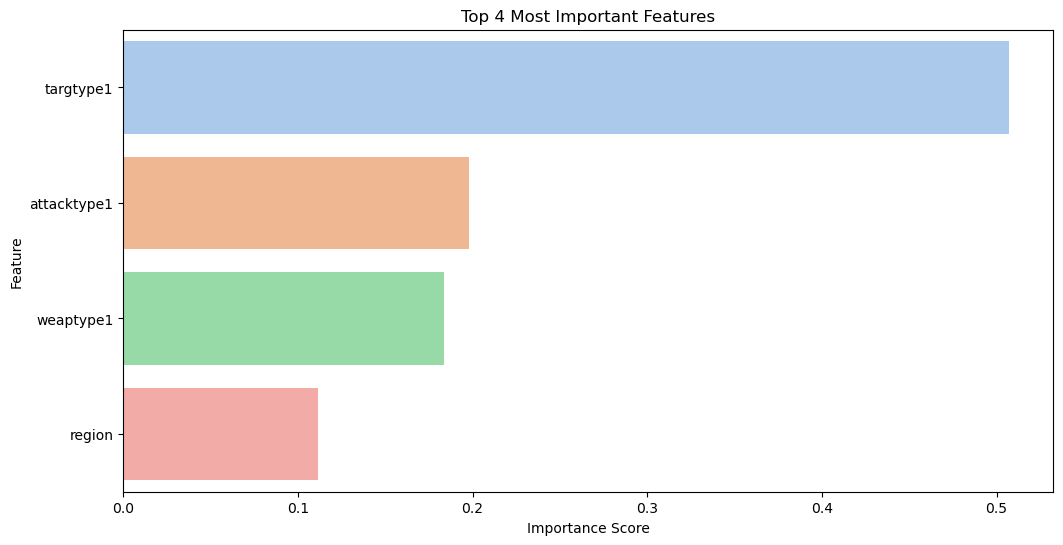

In [60]:
# Getting feature importances from the trained RandomForestClassifier
feature_importances = clf.feature_importances_

# Creating a df to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sorting the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending = False)

# Plotting the top 4 important features
top_n = 4

plt.figure(figsize = (12, 6))
sns.barplot(x = 'Importance', y = 'Feature', data = feature_importance_df.head(top_n), palette = 'pastel')
plt.title(f'Top {top_n} Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Neural Network

In [61]:
# Defining the hyperparameters
hidden_layer_sizes = (50,)
alpha = 0.0001

# Creating the Neural Network classifier with specified hyperparameters
nn_classifier = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, alpha = alpha, random_state = 42, max_iter = 200)

# Fitting the classifier to the training data
nn_classifier.fit(X_train, y_train)

# Evaluating the classifier on the test data
accuracy = nn_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8917087279532694


# __Conclusion__

__This research project embarked on a quest to unravel the intricate dynamics of terrorism across the globe. With a focus on two pivotal research questions — how terrorism hotspots have evolved over the past five decades and the factors contributing to the frequency and scale of terrorist attacks in various regions — I ventured into a comprehensive analysis. After data preprocessing, exploratory data analysis, and the employment of diverse machine learning models, I found the Random Forest model to be the most adept at discerning patterns and predicting terrorism success. By designating "success" as our target variable, I unveiled a multifaceted mosaic of variables, including attack types, target types, regions, and more, that significantly influence the likelihood of a terrorist act achieving its objectives. Through this research, I have contributed to the ever-evolving understanding of global terrorism dynamics and have paved the way for more informed counterterrorism strategies and policies.__

To addres the research questions:

__1. How have terrorism hotspots shifted globally over the last five decades?__
Through exploratory data analysis and machine learning models, we have identified shifts in terrorism hotspots over time, revealing changes in regions with higher frequencies of terrorist incidents.

__2. Which factors contribute most significantly to the frequency and scale of terrorist attacks in different regions?__
The analysis, including statistical and machine learning models, has highlighted the significant impact of various factors, such as attack type, target type, and region, on the frequency and scale of terrorist attacks in different parts of the world.